<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/Hippocampus_TL_Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries Import

In [ ]:
%pip install monai -q
#%pip install torchinfo -q
#%pip install thop -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00


In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime


import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


#from torchinfo import summary
#from thop import profile


from google.colab import drive
print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.13.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.48.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/l

##Drive Mount

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Image, Label and FreeSurferColorLUT Directory

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
image_dir = "MNI_train_data/image_files"
label_dir = "MNI_train_data/label_files_combined"

In [ ]:
lut_path = "FreeSurferColorLUT.txt"

##Image & Labels Extraction and Visualization

In [ ]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

In [ ]:
len(images), len(labels)

(25, 25)

In [ ]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




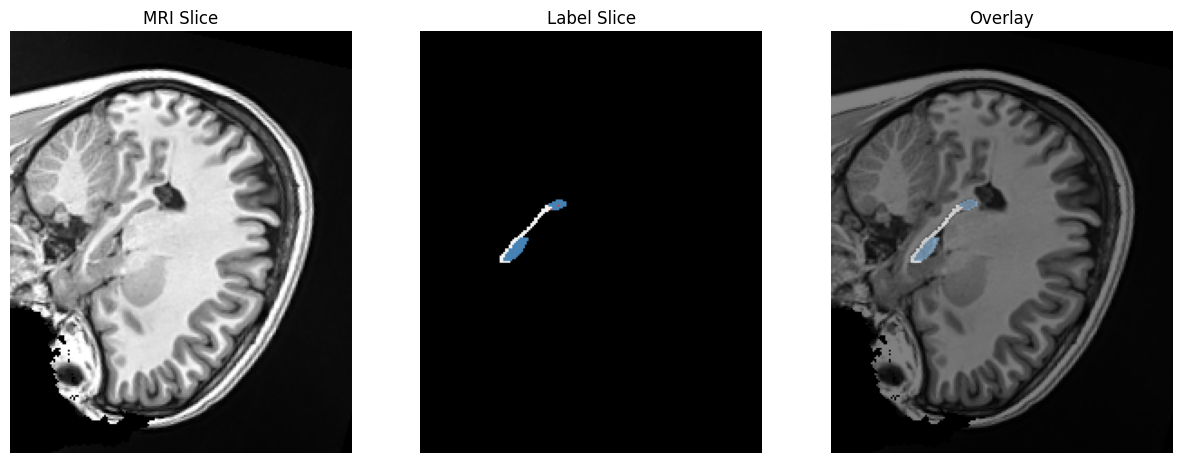

In [ ]:
visualize_image(images[0],labels[0], 75)

##Image Transforms and Custom Dataset

####Transforms

In [ ]:
from monai.transforms import SpatialCrop

In [ ]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    EnsureChannelFirst(),
    SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
])


In [ ]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


##Dataset Loading

In [ ]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]
train_files = data_dicts[:20]
val_files   = data_dicts[20:]


In [ ]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)

In [ ]:
imgt, segt = train_ds[0]
imgt = imgt.squeeze().numpy()
segt = segt.squeeze().numpy()
imgt.shape, segt.shape

((128, 128, 128), (128, 128, 128))

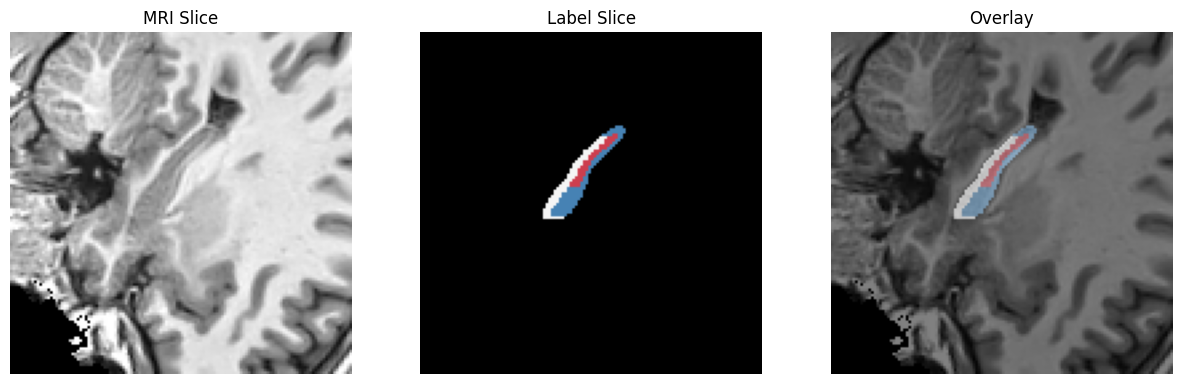

In [ ]:
visualize_image(imgt, segt, 35, array = True)

In [ ]:
def data_details (train_loader, val_loader, test_loader = None):
  print(f"Number of training samples: {len(train_loader) * train_loader.batch_size}")
  print(f"Number of validation samples: {len(val_loader) * val_loader.batch_size}")
  if test_loader:
    print(f"Number of test samples: {len(test_loader) * test_loader.batch_size}")
  train_batch = next(iter(train_loader))
  train_inputs, _ = train_batch
  print(f"Training input size: {train_inputs.shape}")

In [ ]:
data_details(train_loader, val_loader)

Number of training samples: 20
Number of validation samples: 5
Training input size: torch.Size([1, 1, 128, 128, 128])


##Model, Optimizer and Loss Function

In [ ]:
from monai.losses import DiceCELoss

In [ ]:
set_determinism(seed=40)

num_classes = 4

model = SwinUNETR(
    img_size=(128, 128, 128),
    in_channels=1,
    out_channels=num_classes,
    feature_size=48
).cuda()

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


##Loading Pre-Trained Model

In [ ]:
pretrained_dict = torch.load('48_adamw500old_lr-3_best_dice_model.pth')

model_dict = model.state_dict()

filtered_dict = {
    k: v
    for k, v in pretrained_dict.items()
    if k in model_dict and model_dict[k].shape == v.shape
}

model_dict.update(filtered_dict)
model.load_state_dict(model_dict)

<ipython-input-20-c3ffff088d01>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('48_adamw500old_lr-3_best_dice_model.pth')


<All keys matched successfully>

##Freezing Encoder Layers

In [ ]:
for name, param in model.named_parameters():
    if "swinViT" in name:
        param.requires_grad = False

#for name, param in model.named_parameters():
    #if "encoder" in name:
        #param.requires_grad = False

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


swinViT.patch_embed.proj.weight: Frozen
swinViT.patch_embed.proj.bias: Frozen
swinViT.layers1.0.blocks.0.norm1.weight: Frozen
swinViT.layers1.0.blocks.0.norm1.bias: Frozen
swinViT.layers1.0.blocks.0.attn.relative_position_bias_table: Frozen
swinViT.layers1.0.blocks.0.attn.qkv.weight: Frozen
swinViT.layers1.0.blocks.0.attn.qkv.bias: Frozen
swinViT.layers1.0.blocks.0.attn.proj.weight: Frozen
swinViT.layers1.0.blocks.0.attn.proj.bias: Frozen
swinViT.layers1.0.blocks.0.norm2.weight: Frozen
swinViT.layers1.0.blocks.0.norm2.bias: Frozen
swinViT.layers1.0.blocks.0.mlp.linear1.weight: Frozen
swinViT.layers1.0.blocks.0.mlp.linear1.bias: Frozen
swinViT.layers1.0.blocks.0.mlp.linear2.weight: Frozen
swinViT.layers1.0.blocks.0.mlp.linear2.bias: Frozen
swinViT.layers1.0.blocks.1.norm1.weight: Frozen
swinViT.layers1.0.blocks.1.norm1.bias: Frozen
swinViT.layers1.0.blocks.1.attn.relative_position_bias_table: Frozen
swinViT.layers1.0.blocks.1.attn.qkv.weight: Frozen
swinViT.layers1.0.blocks.1.attn.qkv.b

In [ ]:


loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=0.5, lambda_ce=0.5, include_background=True)

trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

post_trans = Compose([
    Activations(softmax=True),
    AsDiscrete(argmax=True, to_onehot=num_classes)
])


##Model Details

In [ ]:
#summary(model, input_size=(1, 1, 128, 128, 128))

In [ ]:
'''
input_tensor = torch.randn(1, 1, 128, 128, 128)
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")
'''

'\ninput_tensor = torch.randn(1, 1, 128, 128, 128)\nflops, params = profile(model, inputs=(input_tensor,))\nprint(f"FLOPs: {flops}")\nprint(f"Parameters: {params}")\n'

##Functions to load and save model and checkpoints

In [ ]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [ ]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [ ]:
#epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('hippo_crop_3rd_f48_Checkpoint.pth')

##Epochs and Validation

In [ ]:
max_epochs = 60
val_interval = 1

###Run if Checkpoints are not loaded

In [ ]:
train_loss_list = []
val_dice_list   = []
epoch_list      = []
epoch=0
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [ ]:
from tqdm import tqdm

In [ ]:
start_epoch=epoch

In [ ]:
checkpoint_path = 'hippo_TL_f48_Checkpoint.pth'
best_model_path = 'hippo_TL_f48_best_dice_model.pth'

#Training Loop
for epoch in range(start_epoch+1, max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in tqdm(train_loader, leave=False):
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")



    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            for val_data in tqdm(val_loader, leave=False):
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (128, 128, 128)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)
        print(f"  Validation Dice: {dice_mean:.4f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")

    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)
print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")


Epoch [41/60] 2025-03-02 11:12:39.516611


  Train loss: 0.0558


  Validation Dice: 0.8463
Epoch [42/60] 2025-03-02 11:13:07.824731


  Train loss: 0.0600


  Validation Dice: 0.8383
Epoch [43/60] 2025-03-02 11:13:36.641552


  Train loss: 0.0588


  Validation Dice: 0.8407
Epoch [44/60] 2025-03-02 11:14:05.879371


  Train loss: 0.0551


  Validation Dice: 0.8424
Epoch [45/60] 2025-03-02 11:14:34.218974


  Train loss: 0.0547


  Validation Dice: 0.8386
Epoch [46/60] 2025-03-02 11:15:02.542088


  Train loss: 0.0537


  Validation Dice: 0.8429
Epoch [47/60] 2025-03-02 11:15:30.885621


  Train loss: 0.0509


  Validation Dice: 0.8485
   Saved new best model
Epoch [48/60] 2025-03-02 11:16:02.332118


  Train loss: 0.0500


  Validation Dice: 0.8444
Epoch [49/60] 2025-03-02 11:16:32.386194


  Train loss: 0.0504


  Validation Dice: 0.8430
Epoch [50/60] 2025-03-02 11:17:00.736528


  Train loss: 0.0488


  Validation Dice: 0.8464
Epoch [51/60] 2025-03-02 11:17:29.531724


  Train loss: 0.0491


  Validation Dice: 0.8348
Epoch [52/60] 2025-03-02 11:17:57.923503


  Train loss: 0.0492


  Validation Dice: 0.8447
Epoch [53/60] 2025-03-02 11:18:26.239095


  Train loss: 0.0478


  Validation Dice: 0.8436
Epoch [54/60] 2025-03-02 11:18:54.531827


  Train loss: 0.0467


  Validation Dice: 0.8436
Epoch [55/60] 2025-03-02 11:19:24.899173


  Train loss: 0.0477


  Validation Dice: 0.8382
Epoch [56/60] 2025-03-02 11:19:53.477306


  Train loss: 0.0462


  Validation Dice: 0.8461
Epoch [57/60] 2025-03-02 11:20:22.577549


  Train loss: 0.0437


  Validation Dice: 0.8395
Epoch [58/60] 2025-03-02 11:20:50.980627


  Train loss: 0.0440


  Validation Dice: 0.8468
Epoch [59/60] 2025-03-02 11:21:19.251625


  Train loss: 0.0436


  Validation Dice: 0.8471
Epoch [60/60] 2025-03-02 11:21:49.792955


  Train loss: 0.0422


  Validation Dice: 0.8467

Training complete. Best val Dice: 0.8485 at epoch 47


##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(60, 60, 60)

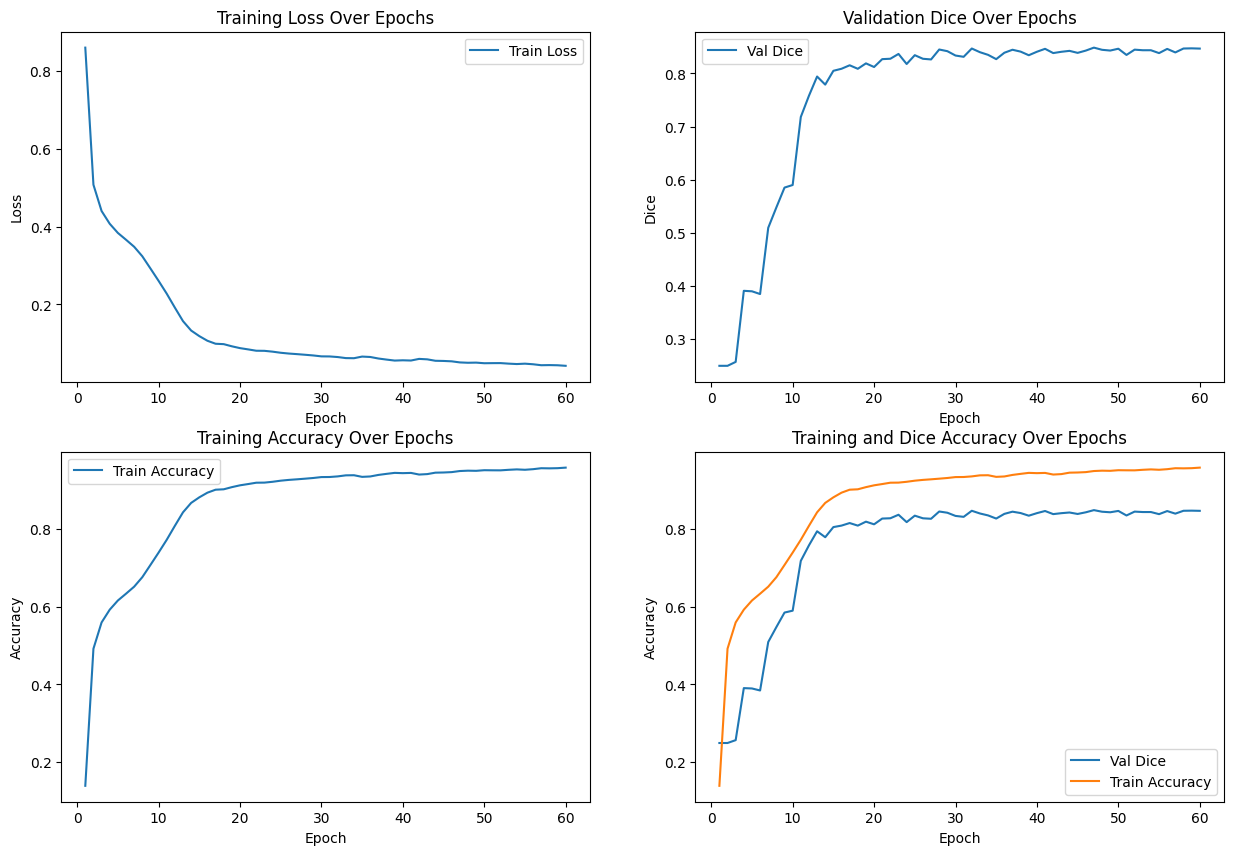

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()

axs[1, 1].plot(epoch_list, val_dice_list, label="Val Dice")
axs[1, 1].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].set_title("Training and Dice Accuracy Over Epochs")
axs[1, 1].legend()

plt.show()

##Model Evaluation

In [ ]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

def dice_score(pred, target, num_classes):
    """
    Calculate Dice score for each class and the combined hippocampus structure.

    Args:
        pred (torch.Tensor): Predicted class indices, shape [batch_size, H, W, D].
        target (torch.Tensor): Ground truth class indices, shape [batch_size, H, W, D].
        num_classes (int): Number of classes.

    Returns:
        dice_scores (torch.Tensor): Dice scores for each class, shape [num_classes].
        hippocampus_dice (torch.Tensor): Dice score for the combined hippocampus structure.
    """
    dice_scores = torch.zeros(num_classes, device=pred.device)

    # Calculate Dice for each class
    for class_idx in range(num_classes):
        pred_mask = (pred == class_idx).float()
        target_mask = (target == class_idx).float()

        intersection = (pred_mask * target_mask).sum()
        pred_volume = pred_mask.sum()
        target_volume = target_mask.sum()

        if pred_volume + target_volume == 0:
            dice_scores[class_idx] = 1.0  # If both masks are empty, Dice is 1
        else:
            dice_scores[class_idx] = (2 * intersection) / (pred_volume + target_volume)

    # Calculate Dice for the combined hippocampus structure (CA1, CA4DG, subiculum)
    hippocampus_classes = [1, 2, 3]  # Assuming CA1=1, CA4DG=2, subiculum=3
    pred_hippocampus = torch.zeros_like(pred, device=pred.device)
    target_hippocampus = torch.zeros_like(target, device=target.device)

    for class_idx in hippocampus_classes:
        pred_hippocampus = pred_hippocampus + (pred == class_idx).float()
        target_hippocampus = target_hippocampus + (target == class_idx).float()

    # Binarize the combined masks
    pred_hippocampus = (pred_hippocampus > 0).float()
    target_hippocampus = (target_hippocampus > 0).float()

    # Calculate Dice for the combined hippocampus
    intersection = (pred_hippocampus * target_hippocampus).sum()
    pred_volume = pred_hippocampus.sum()
    target_volume = target_hippocampus.sum()

    if pred_volume + target_volume == 0:
        hippocampus_dice = 1.0  # If both masks are empty, Dice is 1
    else:
        hippocampus_dice = (2 * intersection) / (pred_volume + target_volume)

    return dice_scores, hippocampus_dice

# Example usage
model.eval()
test_dice_list = []
class_dice = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}

with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (128, 128, 128)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)

        # Convert logits to class indices
        val_outputs = torch.argmax(val_outputs, dim=1)  # Shape: [batch_size, H, W, D]

        # Calculate Dice scores for each class and the combined hippocampus
        dice_scores, hippocampus_dice = dice_score(val_outputs, val_labels, num_classes=4)

        # Store scores
        class_dice['hippocampus'].append(hippocampus_dice.item())
        class_dice['CA1'].append(dice_scores[1].item())
        class_dice['CA4DG'].append(dice_scores[2].item())
        class_dice['subiculum'].append(dice_scores[3].item())

        dice_mean = dice_scores.mean().item()
        test_dice_list.append(dice_mean)

        print(f"Validation Dice - Mean: {dice_mean:.4f}")
        print(f"Hippocampus: {class_dice['hippocampus'][-1]:.4f}, "
              f"CA1: {class_dice['CA1'][-1]:.4f}, "
              f"CA4DG: {class_dice['CA4DG'][-1]:.4f}, "
              f"Subiculum: {class_dice['subiculum'][-1]:.4f}")

# Calculate final statistics
def get_stats(values):
    return np.mean(values), np.std(values)

overall_mean, overall_std = get_stats(test_dice_list)
hippocampus_mean, hippocampus_std = get_stats(class_dice['hippocampus'])
ca1_mean, ca1_std = get_stats(class_dice['CA1'])
ca4dg_mean, ca4dg_std = get_stats(class_dice['CA4DG'])
sub_mean, sub_std = get_stats(class_dice['subiculum'])

print("\nFinal Test Dice Scores:")
print(f"Overall: {overall_mean:.4f} ± {overall_std:.4f}")
print(f"Hippocampus: {hippocampus_mean:.4f} ± {hippocampus_std:.4f}")
print(f"CA1: {ca1_mean:.4f} ± {ca1_std:.4f}")
print(f"CA4DG: {ca4dg_mean:.4f} ± {ca4dg_std:.4f}")
print(f"Subiculum: {sub_mean:.4f} ± {sub_std:.4f}")

<ipython-input-37-44124cf7c64f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Validation Dice - Mean: 0.8039
Hippocampus: 0.8576, CA1: 0.7662, CA4DG: 0.7053, Subiculum: 0.7449
Validation Dice - Mean: 0.8665
Hippocampus: 0.8967, CA1: 0.8236, CA4DG: 0.7864, Subiculum: 0.8563
Validation Dice - Mean: 0.8604
Hippocampus: 0.9050, CA1: 0.8381, CA4DG: 0.8271, Subiculum: 0.7768
Validation Dice - Mean: 0.8509
Hippocampus: 0.9106, CA1: 0.8218, CA4DG: 0.7892, Subiculum: 0.7928
Validation Dice - Mean: 0.8608
Hippocampus: 0.9085, CA1: 0.8350, CA4DG: 0.7819, Subiculum: 0.8266

Final Test Dice Scores:
Overall: 0.8485 ± 0.0228
Hippocampus: 0.8957 ± 0.0196
CA1: 0.8170 ± 0.0262
CA4DG: 0.7780 ± 0.0398
Subiculum: 0.7995 ± 0.0387


In [ ]:
model.eval()
test_dice_list = []
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (128, 128, 128)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)

        dice_mean = dice_metric.aggregate().item()
        test_dice_list.append(dice_mean)
        dice_metric.reset()
        print(f"Validation Dice: {dice_mean:.4f}")

test_dice_mean = np.mean(test_dice_list)
std_dev = np.std(test_dice_list)
print(f"\nTest Dice: {test_dice_mean:.4f}, Std Dev: {std_dev:.4f}")

Validation Dice: 0.8055
Validation Dice: 0.8575
Validation Dice: 0.8670
Validation Dice: 0.8274
Validation Dice: 0.8619

Test Dice: 0.8439, Std Dev: 0.0236


In [ ]:
# Load the model
#load_model(model, '/content/drive/MyDrive/Checkpoints/150_epoch_1e-2_best_model.pth')
model.eval()
# Get validation data
val_img, val_seg = val_ds[0]
val_img_ = val_img.unsqueeze(0).cuda()

# Generate prediction
with torch.no_grad():
    pred_logits = model(val_img_)
    # Apply softmax to get probabilities
    pred_probs = torch.softmax(pred_logits, dim=1)
    # Get the class with highest probability
    pred_label = torch.argmax(pred_probs, dim=1, keepdim=True)  # shape [1,1,D,H,W]

# Convert to numpy for visualization
pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
val_seg_np = val_seg.squeeze().numpy()              # ground truth

print("Predicted label map shape:", pred_label_np.shape)

Predicted label map shape: (128, 128, 128)


In [ ]:
print(np.unique(pred_label_np), len(np.unique(pred_label_np)))

[0 1 2 3] 4


###Changing contiguous labels to standard labels

In [ ]:
STD_LABEL_VALUES = np.array([0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253, 254, 255])

In [ ]:
std_pred_label = STD_LABEL_VALUES[pred_label_np]
std_val_seg = STD_LABEL_VALUES[val_seg_np.astype('int')]

In [ ]:
np.unique(std_pred_label)

array([0, 2, 3, 4])

###Visualization of Predicted and Ground Truth Labels

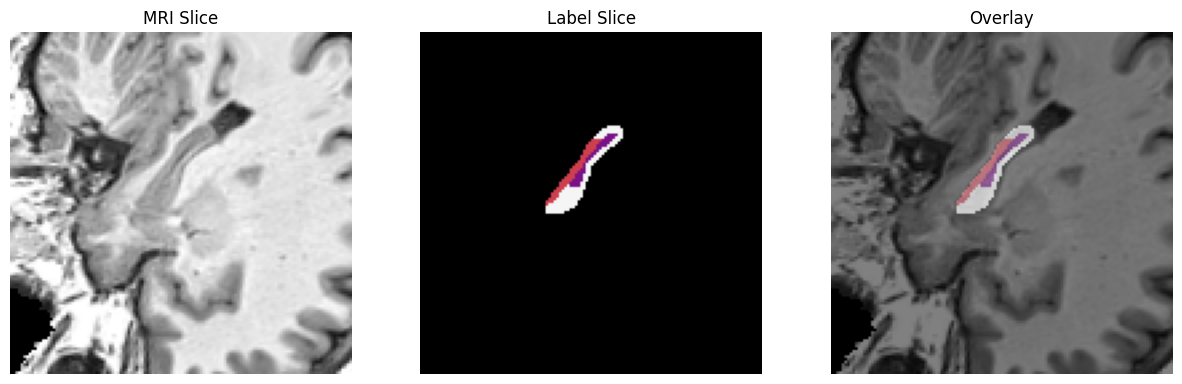

In [ ]:
#Prediction
visualize_image(val_img_np,std_pred_label, 35, array = True)

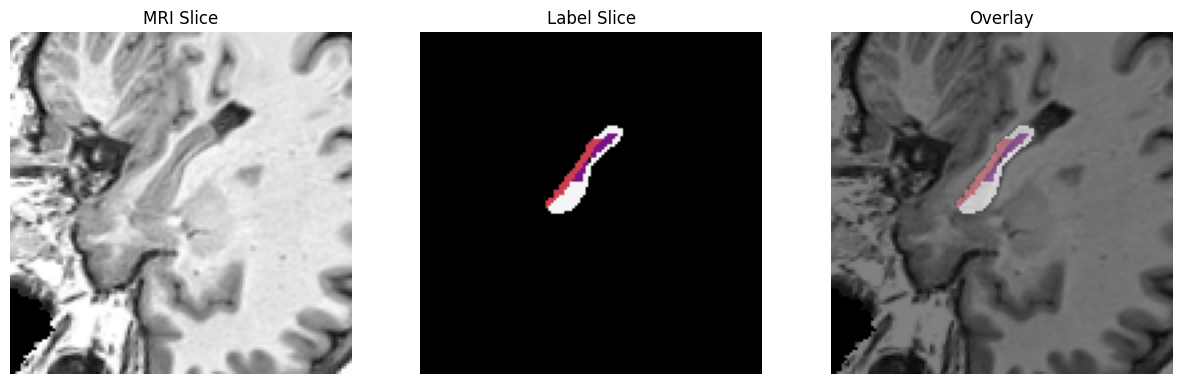

In [ ]:
#Ground Truth
visualize_image(val_img_np, std_val_seg, 35, array = True)